In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# File with functions from prior notebook(s)
from myfunk import *

pd.set_option('precision', 2)

# Update matplotlib defaults to something nicer 
plt_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[10.0,5.0],
              'axes.labelsize':20,
              'axes.titlesize':20,
              'lines.linewidth':3}
sns.set(style="darkgrid", color_codes=True)
plt.rcParams.update(plt_update)

### Load Data

In [3]:
int_data = '../data/processed/dayta.csv'
dayta = pd.read_csv(int_data, index_col=0, parse_dates=['date'])
dayta = dayta.loc[:,['temp','atemp','windspeed', 'humidity']]

data = pd.read_csv('../data/processed/data.csv',parse_dates=['date'])
dayta.head(1)

,temp,atemp,windspeed,humidity
date,,,,
2011-01-01,0.4,0.41,0.25,0.8


## 3. Can the *temperature felt* be characterized by a combination of windspeed, humidity and official temperature? 

A few weather forecasting websites claim that the feels-like-temperature is calculated in function of temperature, humidity and windspeed. I will attempt to find the specific coefficients of the weather predictors to determine it's relationship with the temperature felt. Below the pairplot will show evidence of a (linear or not) relationship

#### Sample per hour 

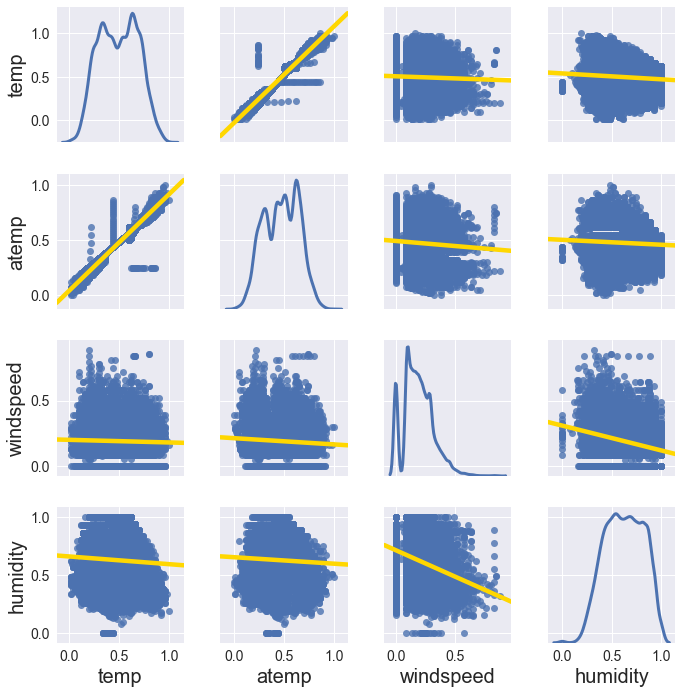

In [9]:
fig = sns.pairplot(data.loc[:,['temp','atemp','windspeed', 'humidity']], kind="reg", plot_kws={'line_kws':{'color':'gold'}}, diag_kind="kde")
fig.savefig('../reports/img/Q3WeatherPairPlotPerHour.png', bbox_inches='tight')

The scatter plot looks a bit noisy and with some outliers around the "feels like" temperature of 0.25. A re-sampling should improve the visibility of the possible relationship. 

#### Sampling per day
Which central metric can be used to represent the variables throughout the day?

The figure below shows the distribution of each weather factor including every hour. It seems to be pretty much a normalized distribution. 

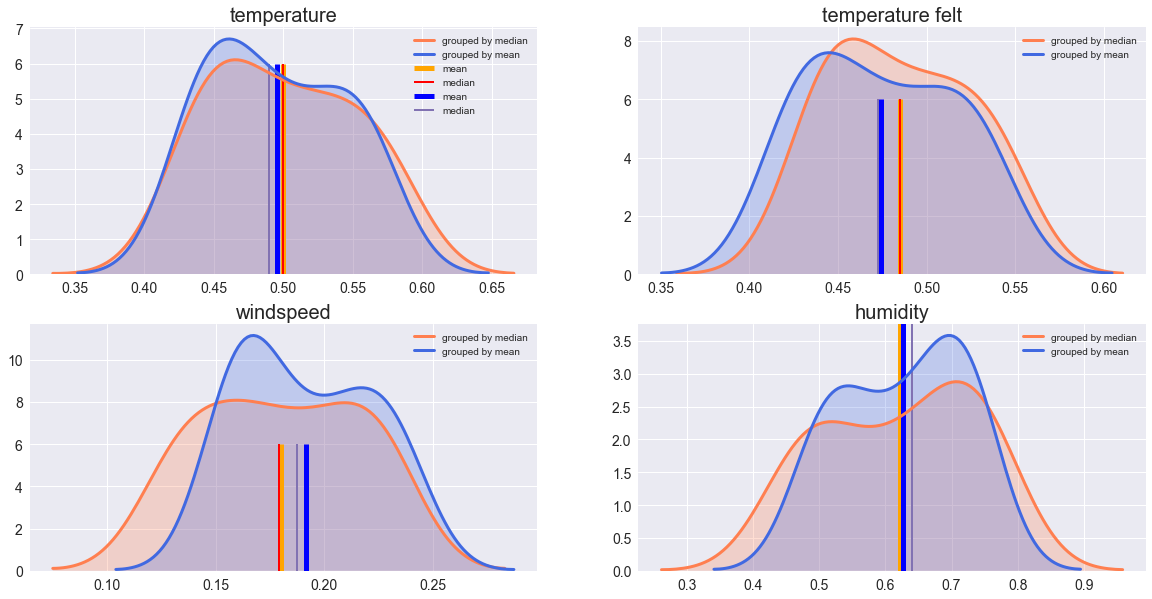

In [38]:
gather_weather_data_per_hour(data)

The weather factors **grouped by median** have lower values of skewness and kurtosis. 

Unfortunately the windspeed and the humidity show no relationship with other factors that can be deduced at the simple eye.

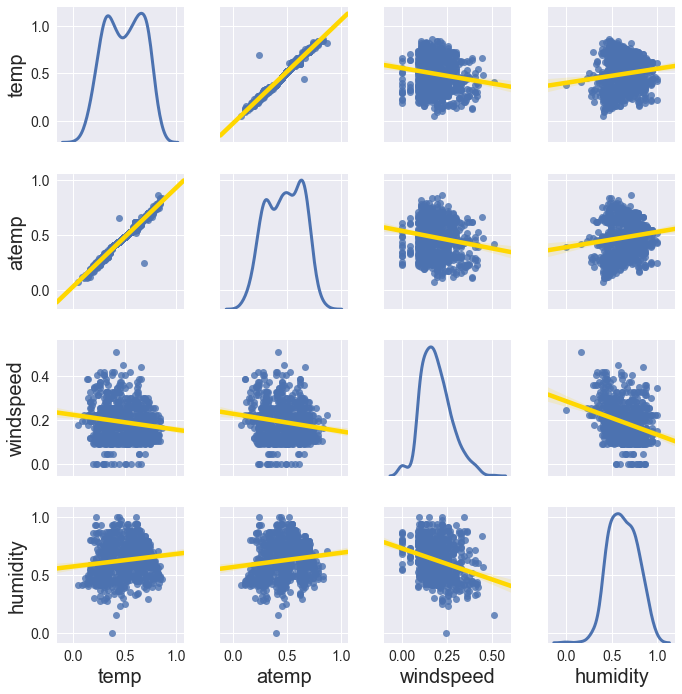

In [12]:
fig = sns.pairplot(dayta.loc[:,['temp','atemp','windspeed', 'humidity']], kind="reg", plot_kws={'line_kws':{'color':'gold'}}, diag_kind="kde")
fig.savefig('../reports/img/Q3WeatherPairPlot.png', bbox_inches='tight')

Unfortunately the windspeed and the humidity show no relationship with other factors that can be deduced at the simple eye.
However the temperature is highly correlated with the temperature felt. 

#### Correlation

In [24]:
# Hourly Data 
data.loc[:,['temp','atemp','windspeed','humidity']].corr().loc['atemp'].drop(['atemp'])

temp         0.99
windspeed   -0.07
humidity    -0.05
Name: atemp, dtype: float64

In [25]:
# Daily Data
dayta.corr().loc['atemp'].drop(['atemp'])

season               4.96e-02
year                 7.33e-03
month               -4.18e-02
holiday             -2.76e-02
dow                 -3.02e-03
workingday           4.62e-02
weather_condition   -1.51e-01
temp                 9.89e-01
windspeed           -1.60e-01
humidity             1.31e-01
casual               5.48e-01
registered           5.39e-01
cnt                  6.28e-01
nCasual              5.48e-01
nRegistered          5.39e-01
nCnt                 6.28e-01
Name: atemp, dtype: float64

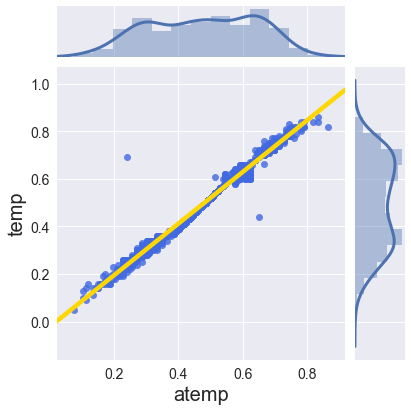

In [36]:
g1 = sns.JointGrid(x="atemp", y="temp", data=dayta) 
g1.plot_joint(sns.regplot, line_kws = {"color":"gold"}, color="royalblue") 
g1.plot_marginals(sns.distplot)
fig.savefig('../reports/img/Q3tempCorrelation.png', bbox_inches='tight')

stats models colinearity function

Could temp and atemp be colinear?? How to prove this? As for the question the temperature felt is not correlated with windspeed nor humidity at all.

Multicolinearity happens when 2 or more independent variables are added to create relations with the dependent variable and end up potentially related between each other.
The Ideal is for all independent variables to be correlated with the dependent variable but NOT with each other

## My Regressions

Real functions: 

In [26]:
# Subset selection

dayta_weather = dayta.loc[:,['temp','atemp','windspeed', 'humidity']]
X = dayta_weather.reset_index()
X.drop(['date','atemp'],inplace=True, axis=1)
y = dayta.reset_index().atemp

mymodels = pd.DataFrame(columns=["Method","RSS", "model"])
mymodels = get_models(mymodels, dayta)
mymodels

,Method,RSS,model
0,single_reg_with_temp,0.43,<statsmodels.regression.linear_model.Regressio...
1,mlr_all_vars,0.42,<statsmodels.regression.linear_model.Regressio...
2,mlr_temp_times_hum,0.42,<statsmodels.regression.linear_model.Regressio...
3,mlr_tmp_sq_temp,0.42,<statsmodels.regression.linear_model.Regressio...
4,Slow_Subset_selection,0.43,<statsmodels.regression.linear_model.Regressio...
5,Slow_Subset_selection,0.42,<statsmodels.regression.linear_model.Regressio...
6,Slow_Subset_selection,0.42,<statsmodels.regression.linear_model.Regressio...
7,Fwd_with_train_and_test,0.22,<statsmodels.regression.linear_model.Regressio...
8,Fwd_with_train_and_test,0.18,<statsmodels.regression.linear_model.Regressio...
9,Fwd_with_train_and_test,0.18,<statsmodels.regression.linear_model.Regressio...


### Results

In [27]:
best_models = pd.DataFrame(columns=["Method","RSS", "model"])

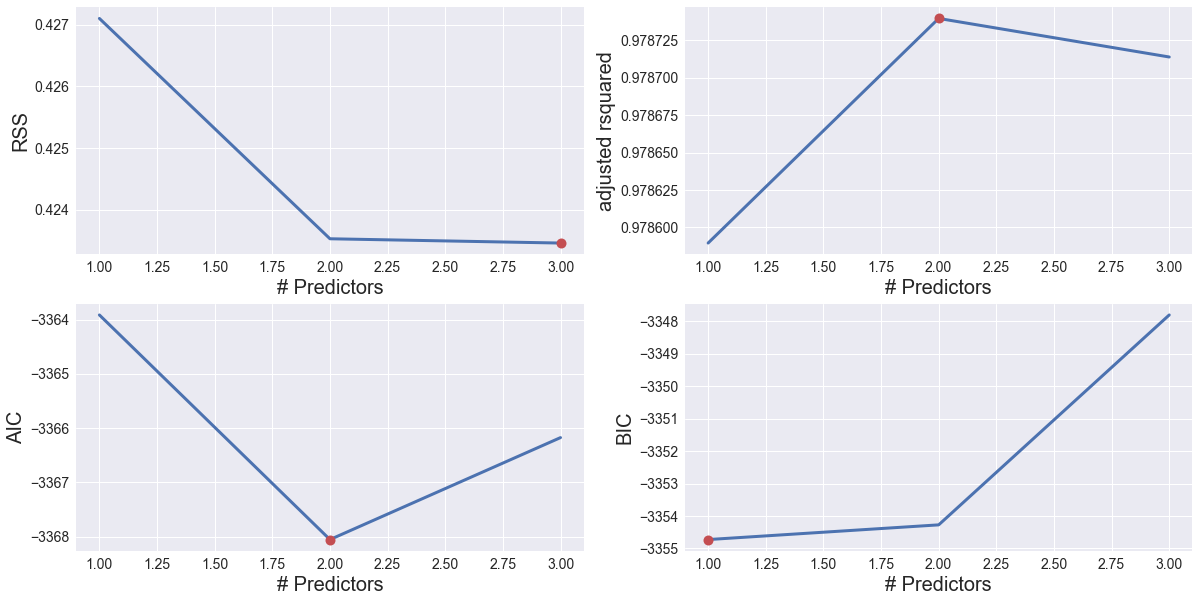

In [37]:
# Random subset Selection
models = mymodels.iloc[4:7,-2:].reset_index()
print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3RandomSubsetSlectionBestModelsResults.png', bbox_inches='tight')

The random subset selection method suggests 2 (temperature and windspeed) to 3 predictors

In [38]:
best_models.loc[0] = ['Randm Subset Selection', models.loc[2].RSS, models.loc[2].model]

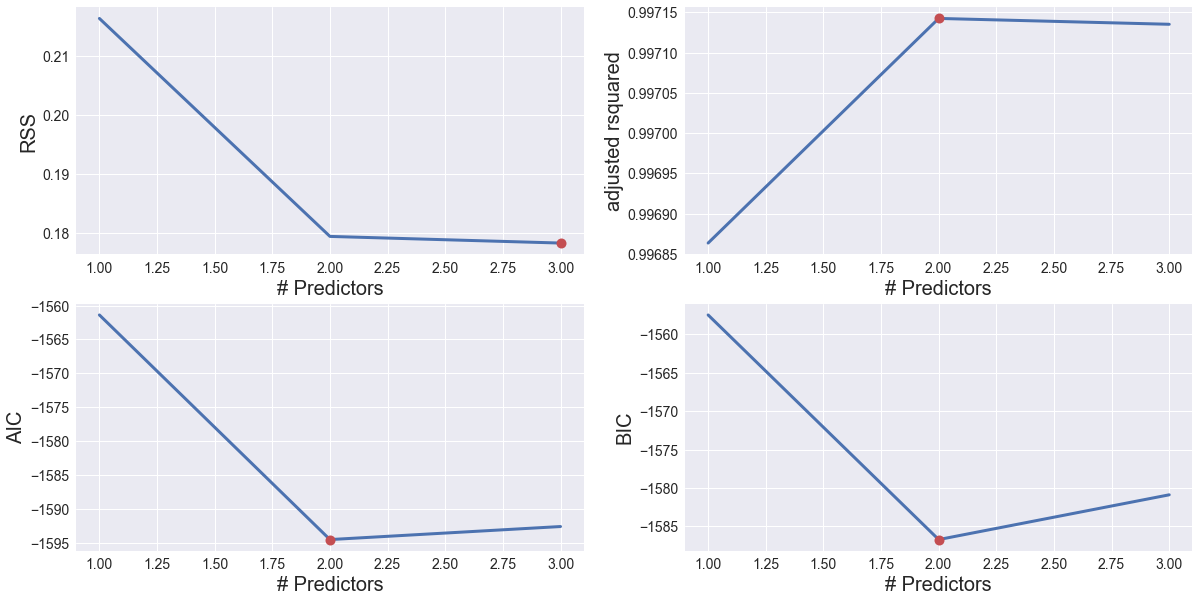

In [39]:
# FWD with train and test
models = mymodels.iloc[7:10,-2:].reset_index()
print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3FwdTrainTestSubsetSlectionBestModelsResults.png', bbox_inches='tight')

The forward subset selection method with training and test set suggests 2 (temperature and humidity)

In [40]:
best_models.loc[1] = ['Fwd subset slctn w train & test', models.loc[2].RSS, models.loc[2].model]

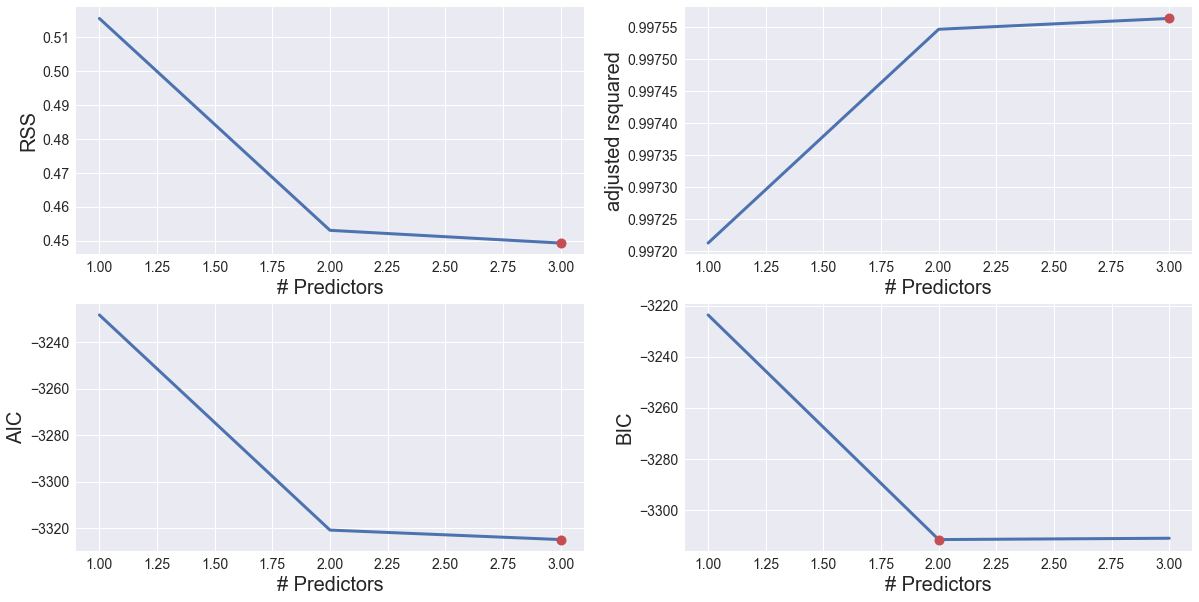

In [44]:
# Fwd_with_full_db
models = mymodels.iloc[10:13,-2:].reset_index()
print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3FwdFullDatasetSubsetSlectionBestModelsResults.png', bbox_inches='tight')

The full dataset forward selection method shows the model with 3 predictors as the best model. 

In [45]:
best_models.loc[2] = ['Fwd subset slctn w full db', models.loc[3].RSS, models.loc[3].model]
models.loc[3].model.params

temp         0.91
humidity     0.03
windspeed    0.02
dtype: float64

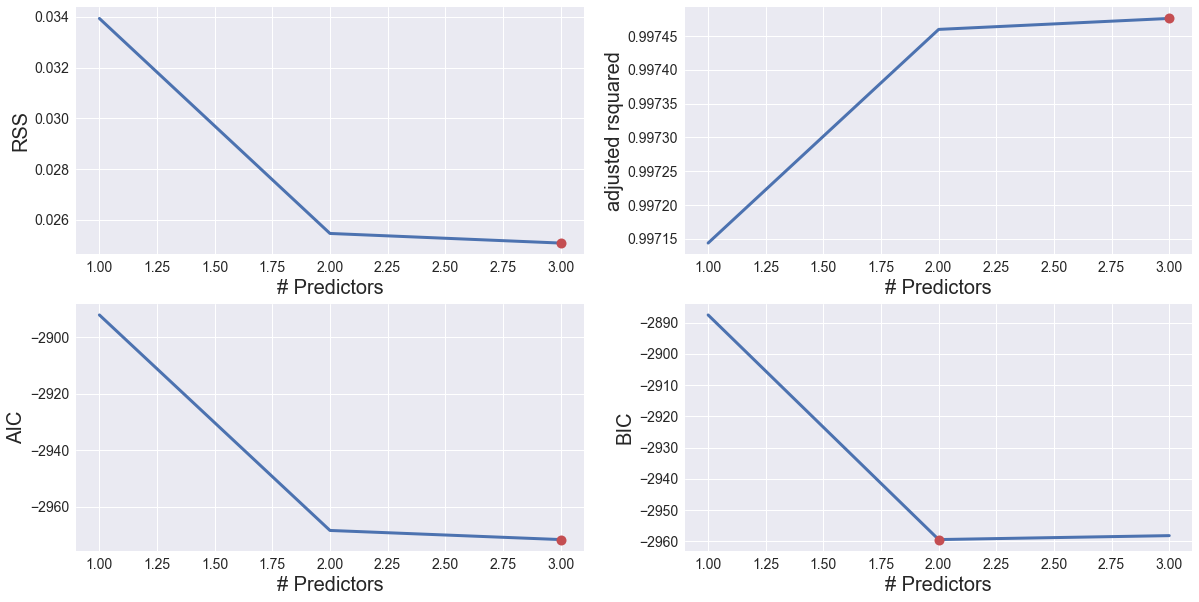

In [52]:
# Cross Validation
models = mymodels.iloc[13:16,-2:].reset_index()
fig=plt.figure()
fig = print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3CVBestModelsResults.png', bbox_inches='tight')

The Cross Validation method shows the model with 3 predictors as the best model. 

In [49]:
best_models.loc[3] = ['Cross Validation', models.loc[3].RSS, models.loc[3].model]
best_models

,Method,RSS,model
0,Randm Subset Selection,0.42,<statsmodels.regression.linear_model.Regressio...
1,Fwd subset slctn w train & test,0.18,<statsmodels.regression.linear_model.Regressio...
2,Fwd subset slctn w full db,0.45,<statsmodels.regression.linear_model.Regressio...
3,Cross Validation,0.03,<statsmodels.regression.linear_model.Regressio...


Each method suggested that 2 to 3 predictors constituted the best prediction model for the temperature felt. 
Furthermore they all agree that the best single predictor is the temperature. Among the best models the Cross Validation method found the model with the least RSS. 

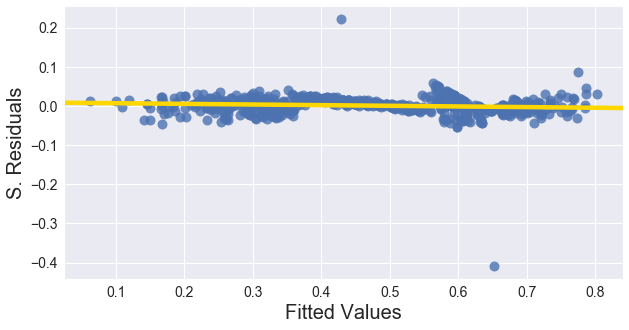

In [50]:
fitted_values = pd.Series(best_models.loc[3,'model'].fittedvalues, name="Fitted Values")
residuals = pd.Series(best_models.loc[3,'model'].resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
fig=plt.figure()
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.show()
fig.savefig('../reports/img/Q3ResidualPlot.png', bbox_inches='tight')

Residuals do not contradict the linear assumption. 
Lets see the quantile-quantile plot of the residuals:

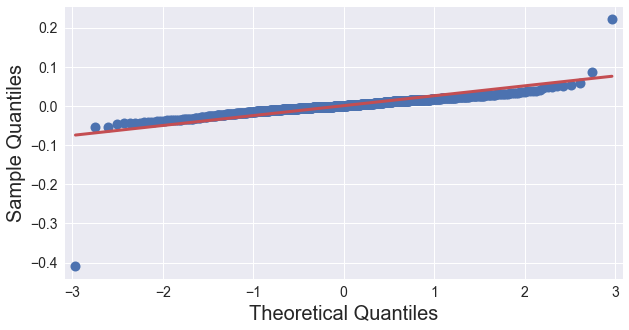

In [53]:
from statsmodels.api import qqplot
fig = plt.figure()
qqplot(best_models.loc[3,'model'].resid, line='s')
plt.show()
fig.savefig('../reports/img/Q3CVBestModelsResults.png', bbox_inches='tight')

The residuals are approximately normally distributed making of the model a good fit. The zone of interest in the q-q plot is the middle so the extreme points in the sides can be ignored. 

In [54]:
best_models.loc[3].model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  atemp   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 8.695e+04
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        23:13:57   Log-Likelihood:                 1488.8
No. Observations:                 660   AIC:                            -2972.
Df Residuals:                     657   BIC:                            -2958.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.9117      0.005    183.553      0.000       0.902       0.921
humidity       0.0322      0.004      7.375      0.000       0.024       0.041
windspeed      0.0218      0.010      2.287      0.023       0.003       0.041
==============================================================================
Omnibus:                      808.352   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           344885.602
Skew:                          -5.434   Prob(JB):                         0.00
Kurtosis:                     114.459   Cond. No.                         8.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary above the temperature felt can be determined in terms of the temperature measured and humidity.

# Polynomials

In the figure below the temperature is plotted ranging from linear to a degree-5 polynomials. 

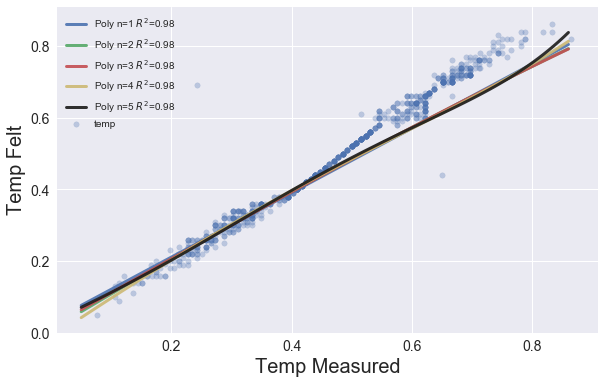

In [32]:
# plot lstat (% lower status of the population) against median value
fig = plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(dayta.atemp, dayta.temp, s=30, alpha=0.3)
plt.xlabel('Temp Measured')
plt.ylabel('Temp Felt')

# points linearlyd space on lstats
x = pd.DataFrame({'temp': np.linspace(dayta.temp.min(), dayta.temp.max(), 100)})

# 1-st order polynomial
poly_1 = smf.ols(formula='atemp ~ 1 + temp', data=dayta).fit()
plt.plot(x.temp, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='atemp ~ 1 + I(temp) + I(temp ** 2.0)', data=dayta).fit()
plt.plot(x.temp, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='atemp ~ 1 + temp - I(temp ** 2.0) + I(temp ** 3.0)', data=dayta).fit()
plt.plot(x.temp, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 4-th order polynomial
poly_4 = smf.ols(formula='atemp ~ 1 + temp - I(temp ** 2.0) + I(temp ** 3.0) + I(temp ** 4.0)', data=dayta).fit()
plt.plot(x.temp, poly_4.predict(x), 'y-', alpha=0.9,
         label='Poly n=4 $R^2$=%.2f' % poly_4.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='atemp ~ 1 + I(temp) - I(temp ** 2.0) + I(temp ** 3.0) + I(temp ** 4.0) + I(temp ** 5.0)', data=dayta).fit()
plt.plot(x.temp, poly_5.predict(x), 'k-', alpha=0.9,
         label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)

plt.legend()
plt.show()
fig.savefig('../reports/img/Q3Polynomials.png', bbox_inches='tight')

In [33]:
print(sm.stats.anova_lm(poly_1, poly_2, poly_3, poly_4, poly_5, typ=1))

   df_resid   ssr  df_diff   ss_diff      F    Pr(>F)
0     729.0  0.43      0.0       NaN    NaN       NaN
1     728.0  0.42      1.0  8.98e-03  16.29  6.02e-05
2     728.0  0.42     -0.0 -1.76e-03    inf       NaN
3     727.0  0.41      1.0  1.03e-02  18.67  1.77e-05
4     726.0  0.40      1.0  9.42e-03  17.09  3.97e-05


The Anova test above shows that the 3rd degree polynomial p value is practically 0 suggesting that it is a good fit. 
However all of them are a good fit since they only differ from each other at the extreme values of the temperature where as the normal values of temperature will show pretty much the same result. 